In [1]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
import random
from scipy.stats import norm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from copy import copy

pd.set_option('display.max_rows', 500)

In [2]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_RESEARCH_SQL_CREDENTIALS'])))
query = """
    select * from research.fish_metadata a left join keypoint_annotations b
    on a.left_url = b.left_image_url 
    where b.keypoints is not null
    and (b.is_qa = false or b.captured_at > '2019-09-19');
"""
df = rds_access_utils.extract_from_database(query)

In [3]:
blacklisted_keypoint_annotation_ids = [
    606484, 
    635806, 
    637801, 
    508773, 
    640493, 
    639409, 
    648536, 
    507003,
    706002,
    507000,
    709298,
    714073,
    719239
]

df = df[~df.id.isin(blacklisted_keypoint_annotation_ids)]

<h1> Apend world keypoints to this data </h1>

In [4]:
BODY_PARTS = sorted([
    'TAIL_NOTCH',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE',
    'UPPER_PRECAUDAL_PIT', 
    'LOWER_PRECAUDAL_PIT',
    'HYPURAL_PLATE'
])


In [17]:
def well_behaved(wkps, cutoff_depth=10.0):
    if any([abs(wkp[1]) > cutoff_depth for wkp in wkps.values()]):
        return False
    return True
    

def flip_center_kps(left_kps, right_kps):
    
    x_min_l = min([kp[0] for kp in left_kps.values()])
    x_max_l = max([kp[0] for kp in left_kps.values()])
    x_mid_l = np.mean([x_min_l, x_max_l])
    
    y_min_l = min([kp[1] for kp in left_kps.values()])
    y_max_l = max([kp[1] for kp in left_kps.values()])
    y_mid_l = np.mean([y_min_l, y_max_l])
    
    x_min_r = min([kp[0] for kp in right_kps.values()])
    x_max_r = max([kp[0] for kp in right_kps.values()])
    x_mid_r = np.mean([x_min_r, x_max_r])
    
    y_min_r = min([kp[1] for kp in right_kps.values()])
    y_max_r = max([kp[1] for kp in right_kps.values()])
    y_mid_r = np.mean([y_min_r, y_max_r])
        
    fc_left_kps, fc_right_kps = {}, {}
    flip_factor = 1 if left_kps['UPPER_LIP'][0] > left_kps['TAIL_NOTCH'][0] else -1
    for bp in BODY_PARTS:
        left_kp, right_kp = left_kps[bp], right_kps[bp]
        if flip_factor > 0:
            fc_left_kp = np.array([left_kp[0] - x_mid_l, left_kp[1] - y_mid_l])
            fc_right_kp = np.array([right_kp[0] - x_mid_l, right_kp[1] - y_mid_l])
        else:
            fc_right_kp = np.array([x_mid_r - left_kp[0], left_kp[1] - y_mid_r])
            fc_left_kp = np.array([x_mid_r - right_kp[0], right_kp[1] - y_mid_r])
        fc_left_kps[bp] = fc_left_kp
        fc_right_kps[bp] = fc_right_kp
        
    return fc_left_kps, fc_right_kps


def _rotate_cc(p, theta):
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    
    rotated_kp = np.dot(R, p)
    return rotated_kp


def rotate_kps(left_kps, right_kps):
    upper_lip_x, upper_lip_y = left_kps['UPPER_LIP']
    theta = np.arctan(upper_lip_y / upper_lip_x)
    r_left_kps, r_right_kps = {}, {}
    for bp in BODY_PARTS:
        rotated_kp = _rotate_cc(left_kps[bp], -theta)
        r_left_kps[bp] = rotated_kp
        disp = abs(left_kps[bp][0] - right_kps[bp][0])
        r_right_kps[bp] = np.array([rotated_kp[0] - disp, rotated_kp[1]])
        
    return r_left_kps, r_right_kps


def translate_kps(left_kps, right_kps, factor):
    t_left_kps, t_right_kps = {}, {}
    for bp in BODY_PARTS:
        left_kp, right_kp = left_kps[bp], right_kps[bp]
        t_left_kps[bp] = factor * np.array(left_kps[bp])
        t_right_kps[bp] = factor * np.array(right_kps[bp])
    
    return t_left_kps, t_right_kps


def jitter_kps(left_kps, right_kps, jitter):
    j_left_kps, j_right_kps = {}, {}
    for bp in BODY_PARTS:
        j_left_kps[bp] = np.array([left_kps[bp][0] + np.random.normal(0, jitter), 
                                   left_kps[bp][1] + np.random.normal(0, jitter)])
        j_right_kps[bp] = np.array([right_kps[bp][0] + np.random.normal(0, jitter), 
                                    right_kps[bp][1] + np.random.normal(0, jitter)])
    
    return j_left_kps, j_right_kps



def modify_kps(left_kps, right_kps, factor, jitter, cm):
    fc_left_kps, fc_right_kps = flip_center_kps(left_kps, right_kps)
    r_left_kps, r_right_kps = rotate_kps(fc_left_kps, fc_right_kps)
    t_left_kps, t_right_kps = translate_kps(r_left_kps, r_right_kps, factor)
    j_left_kps, j_right_kps  = jitter_kps(t_left_kps, t_right_kps, jitter)
    j_left_kps_list, j_right_kps_list = [], []
    for bp in BODY_PARTS:
        l_item = {
            'keypointType': bp,
            'xFrame': j_left_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
            'yFrame': j_left_kps[bp][1] + cm['pixelCountHeight'] / 2.0
        }
        
        r_item = {
            'keypointType': bp,
            'xFrame': j_right_kps[bp][0] + cm['pixelCountWidth'] / 2.0,
            'yFrame': j_right_kps[bp][1] + cm['pixelCountHeight'] / 2.0
        }
        
        j_left_kps_list.append(l_item)
        j_right_kps_list.append(r_item)
        
    modified_kps = {
        'leftCrop': j_left_kps_list,
        'rightCrop': j_right_kps_list
    }
    
    return modified_kps


def process_df(df, n_factors=1, jitters=[0, 10, 20], low=0.3, high=2, oos=False, network=None):
    features_data = defaultdict(list)
    
    row_count = 0
    for idx, row in df.iterrows():
        keypoints = row.keypoints
        left_keypoints_list = keypoints.get('leftCrop')
        right_keypoints_list = keypoints.get('rightCrop')
        cm = row.camera_metadata
        if left_keypoints_list and right_keypoints_list:
            wkps = pixel2world(left_keypoints_list, right_keypoints_list, cm)
            left_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in left_keypoints_list}
            right_kps = {item['keypointType']: np.array([item['xFrame'], item['yFrame']]) for item in right_keypoints_list}
            if well_behaved(wkps):
                for n in range(n_factors):
                    factor = 1.0 if n_factors == 1 else np.random.uniform(low=low, high=high)
                    for jitter in jitters:
                        trials = 3 if jitter > 0 else 1
                        for t in range(trials):
                            modified_kps = modify_kps(left_kps, right_kps, factor, jitter, cm)
                            modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)

                            for i in range(len(BODY_PARTS)-1):
                                for j in range(i+1, len(BODY_PARTS)):
                                    d = euclidean_distance(modified_wkps[BODY_PARTS[i]], 
                                                           modified_wkps[BODY_PARTS[j]])
                                    features_data['{0}-{1}'.format(i, j)].append(d)
                            
                            features_data['weight'].append(row.weight)
                            features_data['captured_at'].append(row.captured_at)
                            features_data['gtsf_fish_identifier'].append(row.fish_id)
                            features_data['keypoint_annotation_id'].append(row.id)
                            features_data['world_keypoints'].append(modified_wkps)
        if row_count % 1000 == 0:
            print('Percentage complete: {}'.format(row_count / df.shape[0]))
        row_count += 1
                            
    
    return features_data






In [18]:
features_data = process_df(df)

Percentage complete: 0.0
Percentage complete: 0.06272738677706687
Percentage complete: 0.12545477355413373
Percentage complete: 0.1881821603312006
Percentage complete: 0.25090954710826746
Percentage complete: 0.3136369338853343
Percentage complete: 0.3763643206624012
Percentage complete: 0.43909170743946807
Percentage complete: 0.5018190942165349
Percentage complete: 0.5645464809936018
Percentage complete: 0.6272738677706686
Percentage complete: 0.6900012545477355
Percentage complete: 0.7527286413248024
Percentage complete: 0.8154560281018692
Percentage complete: 0.8781834148789361
Percentage complete: 0.940910801656003


In [19]:
features_df = pd.DataFrame(features_data)

In [22]:
# define all features

body_parts_subset = sorted([
    'HYPURAL_PLATE',
    'ADIPOSE_FIN',
    'ANAL_FIN',
    'PECTORAL_FIN',
    'PELVIC_FIN',
    'DORSAL_FIN',
    'UPPER_LIP',
    'EYE'
])

body_part_indices = [BODY_PARTS.index(bp) for bp in body_parts_subset]

pairwise_distance_columns = ['{0}-{1}'.format(x, y) for x, y in list(combinations(body_part_indices, 2))]
interaction_columns_quadratic = []
interaction_columns_cubic = []
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        col1 = pairwise_distance_columns[i]
        col2 = pairwise_distance_columns[j]
        interaction_column = '{},{}'.format(col1, col2)
        features_df[interaction_column] = features_df[col1] * features_df[col2]
        interaction_columns_quadratic.append(interaction_column)
        
for i in range(len(pairwise_distance_columns)):
    for j in range(i, len(pairwise_distance_columns)):
        for k in range(j, len(pairwise_distance_columns)):
            col1 = pairwise_distance_columns[i]
            col2 = pairwise_distance_columns[j]
            col3 = pairwise_distance_columns[k]
            interaction_column = '{},{},{}'.format(col1, col2, col3)
            features_df[interaction_column] = features_df[col1] * features_df[col2] * features_df[col3]
            interaction_columns_cubic.append(interaction_column)
            

<h1> Train Linear Model </h1>

In [28]:
weights = []
i = 0
for idx, row in features_df.iterrows():
    if i % 100 == 0:
        print(i)
    i += 1
    count = features_df[features_df.gtsf_fish_identifier == row.gtsf_fish_identifier].shape[0]
    if count > 1:
        weights.append(1.0 / count ** 0.5)
#         weights.append(1.0 / count)
    else:
        weights.append(1)
        
features_df['w'] = weights

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [29]:
def generate_train_mask(df, train_frac, randomize=True):
    x = np.zeros((df.shape[0]), dtype=bool)
    x[:int(train_frac * df.shape[0])] = True
    np.random.shuffle(x)
    mask = pd.Series(x)
    return x
    

def generate_oos_score(features_df, mask, train_size, num_eigenvectors):
    np.random.seed(0)
    columns = pairwise_distance_columns + interaction_columns_quadratic + interaction_columns_cubic

    X_train = features_df.loc[mask, columns].values
    y_train = features_df.loc[mask, 'weight'].values
    w_train = features_df.loc[mask, 'w'].values
    X_test = features_df.loc[~mask, columns].values
    y_test = features_df.loc[~mask, 'weight'].values

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)

    pca = PCA(n_components=min(X_train_normalized.shape[0], X_train_normalized.shape[1]))
    pca.fit(X_train_normalized)
    explained_variance_ratio = pca.explained_variance_ratio_.cumsum()
    idx = num_eigenvectors

    pca = PCA(n_components=idx+1)
    pca.fit(X_train_normalized)
    X_train_transformed = pca.transform(X_train_normalized)
    X_test_normalized = scaler.transform(X_test)
    X_test_transformed = pca.transform(X_test_normalized)

    reg = LinearRegression().fit(X_train_transformed, y_train, sample_weight=w_train)
    score = reg.score(X_test_transformed, y_test)

    y_pred = reg.predict(pca.transform(scaler.transform(features_df[columns].values)))
    features_df['prediction'] = y_pred
    features_df['error'] = features_df.prediction - features_df.weight
    features_df['error_pct'] = features_df.error / features_df.weight
    features_df['abs_error_pct'] = features_df.error_pct.abs()

    model = {
    'mean': scaler.mean_,
    'std': scaler.scale_,
    'PCA_components': pca.components_,
    'reg_coef': reg.coef_,
    'reg_intercept': reg.intercept_,
    'body_parts': body_parts_subset   
    }
    

    return mask, model, score



In [41]:
# num eigenvectors = 20

train_size = 2000
gtsf_fish_identifiers = list(features_df.gtsf_fish_identifier.unique())
fish_ids = random.sample(gtsf_fish_identifiers, train_size)
date_mask = (features_df.captured_at < '2019-09-01') 
mask = date_mask & features_df.gtsf_fish_identifier.isin(fish_ids)
mask, model, score = generate_oos_score(features_df, mask, 2000, 20)

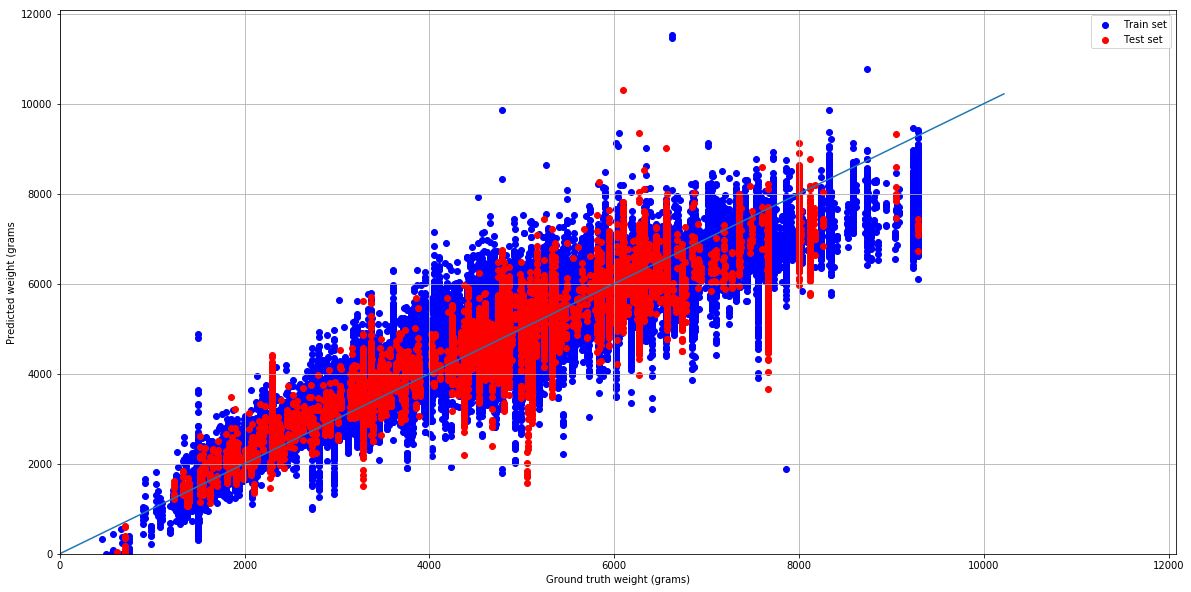

In [42]:
%matplotlib inline
amg = AccuracyMetricsGenerator()
test_mask = date_mask & ~features_df.gtsf_fish_identifier.isin(fish_ids)
amg.set_data(mask, features_df.prediction.values, features_df.weight.values, w=features_df.w.values, test_mask=test_mask)
amg.plot_predictions_vs_ground_truth(impose_bounds=True)

In [43]:
amg.display_train_test_accuracy_metrics()

=============== TRAIN SET METRICS ===============
avg_per_fish_abs_err: 472.147
avg_per_fish_abs_pct_err: 0.19174
avg_per_fish_err: 3.7187e-12
avg_per_fish_pct_err: -0.058913
biomass_err: 3.638e-12
biomass_error_pct: 7.8935e-16
median_per_fish_abs_err: 366.971
median_per_fish_abs_pct_err: 0.084841
median_per_fish_err: 61.196
median_per_fish_pct_err: 0.014499
std_per_fish_pct_err: 0.76828

=============== TEST SET METRICS ===============
avg_per_fish_abs_err: 467.666
avg_per_fish_abs_pct_err: 0.17626
avg_per_fish_err: -93.864
avg_per_fish_pct_err: -0.068679
biomass_err: -93.864
biomass_error_pct: -0.019671
median_per_fish_abs_err: 352.798
median_per_fish_abs_pct_err: 0.078278
median_per_fish_err: -31.209
median_per_fish_pct_err: -0.0067627
std_per_fish_pct_err: 0.75361


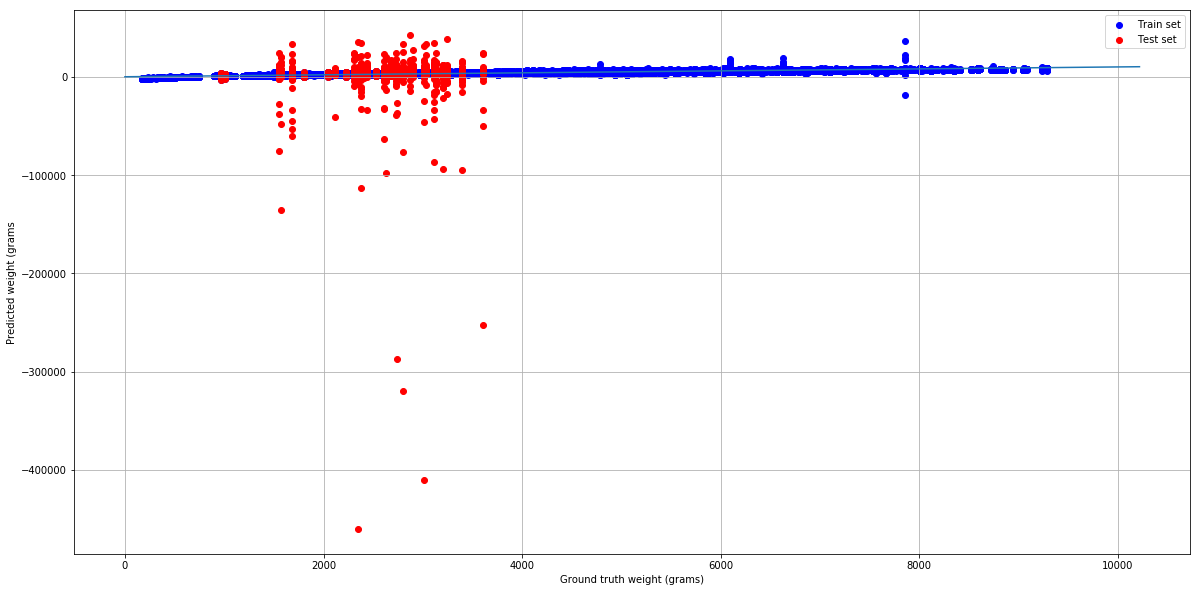

In [49]:
%matplotlib inline
amg = AccuracyMetricsGenerator()
test_mask = ~date_mask
amg.set_data(mask, features_df.prediction.values, features_df.weight.values, w=features_df.w.values, test_mask=test_mask)
amg.plot_predictions_vs_ground_truth(impose_bounds=False)

In [45]:
amg.display_train_test_accuracy_metrics()

=============== TRAIN SET METRICS ===============
avg_per_fish_abs_err: 472.147
avg_per_fish_abs_pct_err: 0.19174
avg_per_fish_err: 3.7187e-12
avg_per_fish_pct_err: -0.058913
biomass_err: 3.638e-12
biomass_error_pct: 7.8935e-16
median_per_fish_abs_err: 366.971
median_per_fish_abs_pct_err: 0.084841
median_per_fish_err: 61.196
median_per_fish_pct_err: 0.014499
std_per_fish_pct_err: 0.76828

=============== TEST SET METRICS ===============
avg_per_fish_abs_err: 2471.874
avg_per_fish_abs_pct_err: 1.023
avg_per_fish_err: -293.94
avg_per_fish_pct_err: -0.13808
biomass_err: -293.94
biomass_error_pct: -0.12343
median_per_fish_abs_err: 613.572
median_per_fish_abs_pct_err: 0.28189
median_per_fish_err: 272.264
median_per_fish_pct_err: 0.10565
std_per_fish_pct_err: 5.845


AttributeError: 'DataFrame' object has no attribute 'depth'

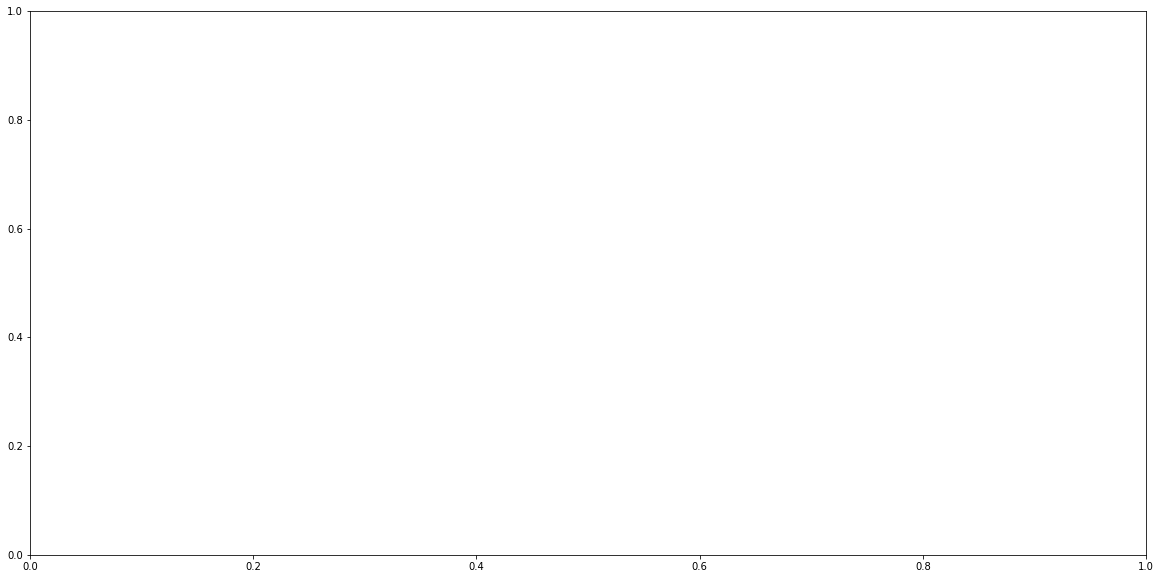

In [48]:
%matplotlib inline
mask = features_df.captured_at < '2019-09-10'
fig, ax = plt.subplots(figsize=(20, 10))
sc = ax.scatter(features_df[~mask].weight.values, features_df[~mask].prediction.values, c=features_df[~mask].depth.values)
plt.colorbar(sc)
plt.plot([0, 5e3], [0, 5e3], color='red')
plt.xlim([0, 5e3])
plt.ylim([0, 2e4])
plt.xlabel('Ground truth weight (grams)')
plt.ylabel('Predicted weight (grams)')
plt.title('Prediction vs. Ground Truth: fish far away from camera, Linear PCA')
plt.grid()
plt.show()